In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def generate_exploring_start(env):
    """
    Make sure that we start from a random (s, a) pair as first step
    :param env: 
    :return: 
        A tuple (starting, state, action, reward, next_state, game_over)
    """
    
    # select state with equal prob
    starting_state = env.reset()
    
    # select action with equal prob
    action = np.random.randint(2)
    
    next_state, reward, game_over, _ = env.step(action) 
    
    return starting_state, action, reward, next_state, game_over


In [5]:
def generate_episode(env, policy_fn, starting_state=None):
    """
    
    :param env: 
    :param policy_fn: 
    :param starting_state: 
    :return: 
    """
    episode = []
    
    state = starting_state
    if state is None:
        state = env.reset()
    
    game_over = False
    
    while not game_over:
        action = policy_fn(state)        
        next_state, reward, game_over, _ = env.step(action)
        episode.append((state, action, reward))
        if game_over:
            break
        else:
            state = next_state
    
    return episode


In [6]:
def generate_episode_with_exploring_start(env, policy_fn):
    """
    Generates an episode given a policy
    
    :param env:
         Env with which to interact
    :param policy_fn: 
        A function that maps state to action
    :return: 
        An episode  - that is an array of (state, action, reward) tuples 
    """
    episode = []
    
    start_state, action, reward, next_state, game_over = generate_exploring_start(env)
    episode.append((start_state, action, reward))
    
    if game_over:
        return episode           
            
    return episode + generate_episode(env, policy_fn, starting_state=next_state)


In [7]:
def create_greedy_policy(q_function):
    """
    Makes new improved policy function from estimated q
    
    :param q: 
        Action-value function
    :return: 
        Newly created greedy policy, based on q
    """
    greedy_state_to_action_map = defaultdict(int)
    for state, action_returns in q_function.items():
        greedy_state_to_action_map[state] = np.argmax(action_returns)
    
    def policy_fn(state_):
        return greedy_state_to_action_map[state_]
    
    return policy_fn


In [8]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1


In [9]:
def update_q_function_from_episode(Q, counts, episode):       
    """
    
    :param Q: 
    :param counts: 
    :param episode: 
    :return: 
    """
    accumulated_return = 0
    returns_for_episode = {}        
    # As we going backwards, returns will be calculated for first-entry of the states
    episode.reverse()
    for (state, action, reward) in episode:
        accumulated_return += reward 
        returns_for_episode[(state, action)] = accumulated_return
    
    for (state, action), return_ in returns_for_episode.items():
        counts[(state, action)] += 1
        # Do averaging update https://math.stackexchange.com/questions/106700/incremental-averageing
        Q[state][action] += (return_ - Q[state][action]) / counts[(state, action)]  


In [10]:
def mc_control_greedy_exploring_starts(env, num_episodes):
    """
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    counts = defaultdict(float)
    
    policy_fn = sample_policy
    
    for _ in range(num_episodes):
        episode = generate_episode_with_exploring_start(env, policy_fn)
        
        update_q_function_from_episode(Q, counts, episode)
        
        policy_fn = create_greedy_policy(Q)
    
    return Q, policy_fn


In [19]:
Q_final, policy_final = mc_control_greedy_exploring_starts(env, num_episodes=500000)

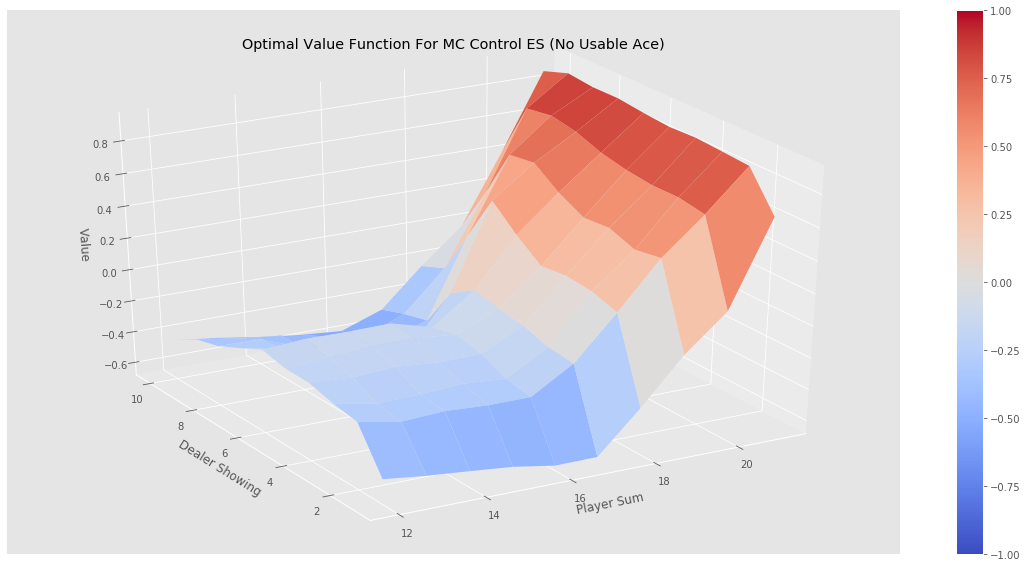

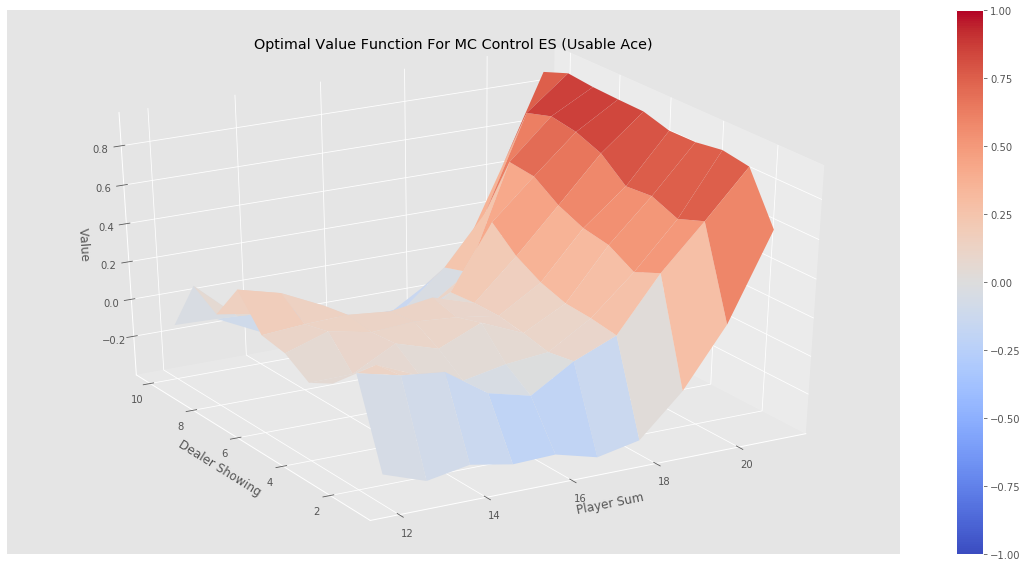

In [12]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q_final.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function For MC Control ES")

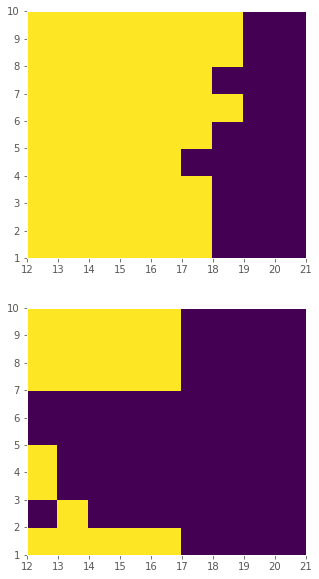

In [22]:
from lib import plotting
plotting.plot_blackjack_policy_on_grid(policy_final)

In [14]:
def make_epsilon_greedy_policy(Q, epsilon):
    """    
    """
    epsilon_greedy_state_to_action_map = defaultdict(lambda: np.full(env.action_space.n, 1 / env.action_space.n))
    for state, action_returns in Q.items():
        best_action_so_far = np.argmax(action_returns)
        
        def get_prob(action):
            if action == best_action_so_far:
                return (1 - epsilon) + epsilon / len(action_returns)
            else:
                return epsilon / len(action_returns)
            
        probs = [get_prob(action) for action in range(len(action_returns))]
        epsilon_greedy_state_to_action_map[state] = np.array(probs)         
    
    def policy_fn(state_):    
        action_probs = epsilon_greedy_state_to_action_map[state_]
        
        return np.random.choice(range(len(action_probs)), p=action_probs)
                    
    return policy_fn



In [12]:
np.full(env.action_space.n, 1 / env.action_space.n)

array([0.5, 0.5])

In [13]:
def mc_control_epsilon_greedy(env, num_episodes, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.        
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    counts = defaultdict(float)
    
    policy_fn = sample_policy
    
    for _ in range(num_episodes):
        episode = generate_episode(env, policy_fn)
        
        update_q_function_from_episode(Q, counts, episode)
        
        policy_fn = make_epsilon_greedy_policy(Q, epsilon)
    
    return Q, policy_fn

In [15]:
Q_epsilon_greedy_final, policy_epsilon_greedy_final = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

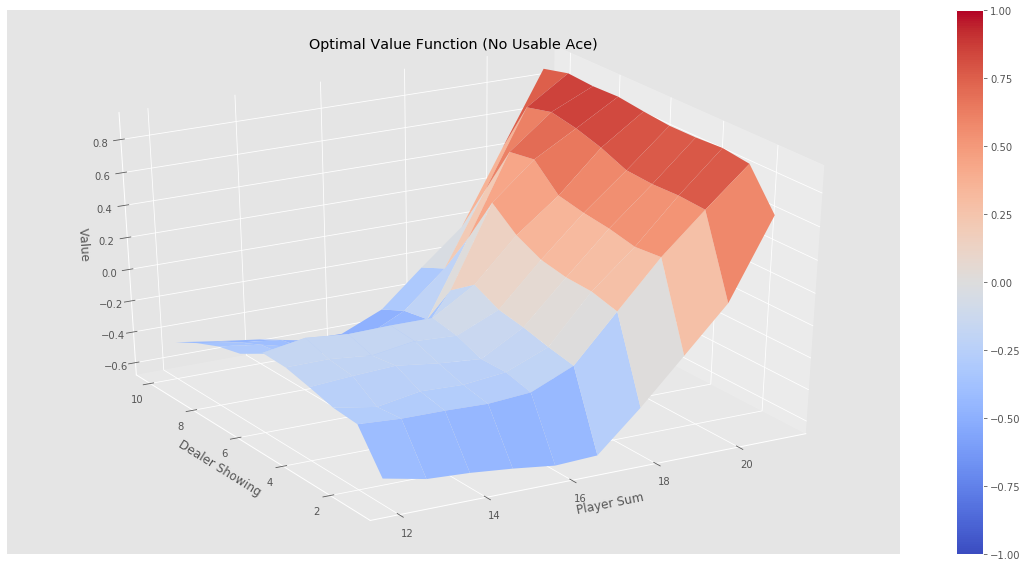

In [ ]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q_epsilon_greedy_final.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

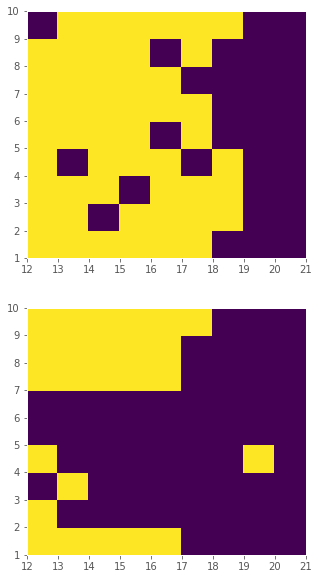

In [17]:
from lib import plotting
plotting.plot_blackjack_policy_on_grid(policy_epsilon_greedy_final)